In [2]:
# -*- coding: utf-8 -*-
"""
Spyder Editor

This is a temporary script file.
"""
#import cv2
import matplotlib.pyplot as plt
import os
from os.path import join
import numpy as np
from PIL import Image
import matplotlib.image as mpimg
from skimage.color import rgb2gray
from skimage.color import label2rgb
from skimage.filters import gaussian
from sklearn.cluster import KMeans
import sys #Self Imported

plt.close('all')
clear = lambda: os.system('clear')
clear()
np.random.seed(110)

colors = [[1,0,0],[0,1,0],[0,0,1],[0,0.5,0.5],[0.5,0,0.5]]

imgNames = ['water_coins','jump','tiger']#{'balloons', 'mountains', 'nature', 'ocean', 'polarlights'};
segmentCounts = [2,3,4,5]


# figure to plot
img_mat = np.empty((3,4),dtype=object)


i = 0
for imgName in imgNames:
    j = 0
    for SegCount in segmentCounts:
        # Load the imageusing OpenCV        
        img = mpimg.imread('Input/'+imgName+'.png')
        print('Using Matplotlib Image Library: Image is of datatype ',img.dtype,'and size ',img.shape) # Image is of type float 

        # Load the Pillow-- the Python Imaging Library
        img = Image.open('Input/'+imgName+'.png') 
        print('Using Pillow (Python Image Library): Image is of datatype ', img.mode , ' (3x8-bit pixels, true color) '   ,'and size ',img.size) # Image is of type uint8  
        
        #%% %Define Parameters
        nSegments = SegCount   # of color clusters in image
        nPixels = img.height * img.width;    # Image can be represented by a matrix of size nPixels*nColors
        maxIterations = 20; #maximum number of iterations allowed for EM algorithm.
        nColors = 3;
        
        #%% Determine the output path for writing images to files
        outputPath = join(''.join(['Output/',str(SegCount), '_segments/', imgName , '/']));
        
        if not(os.path.exists(outputPath)):
            os.makedirs(outputPath)
        """ save input image as *0.png* under outputPath-- 3 points""" #save using Matplotlib image library
        mpimg.imsave(outputPath + '0.png', np.asarray(img))
        #%% Vectorizing image for easier loops- done as im(:) in Matlab
        pixels = img
        img = np.asarray(img)
        pixels = np.asarray(pixels).reshape(nPixels,nColors,1)
        final_img = img
        
        
        #%%
        """ Initialize pi (mixture proportion) vector and mu matrix (containing means of each distribution)
            Vector of probabilities for segments... 1 value for each segment.
            Best to think of it like this...
            When the image was generated, color was determined for each pixel by selecting
            a value from one of "n" normal distributions. Each value in this vector 
            corresponds to the probability that a given normal distribution was chosen."""
        
        
        """ Initial guess for pi's is 1/nSegments. Small amount of noise added to slightly perturb 
           GMM coefficients from the initial guess"""
           
        pi = 1/nSegments*(np.ones((nSegments, 1),dtype='float'))
        increment = np.random.normal(0,.0001,1)
        for seg_ctr in range(len(pi)):
            if(seg_ctr%2==1):
                pi[seg_ctr] = pi[seg_ctr] + increment
            else:
                pi[seg_ctr] = pi[seg_ctr] - increment
                
         #%% 
        """Similarly, the initial guess for the segment color means would be a perturbed version of [mu_R, mu_G, mu_B],
           where mu_R, mu_G, mu_B respectively denote the means of the R,G,B color channels in the image.
           mu is a nSegments X nColors matrrix,(seglabels*255).np.asarray(int) where each matrix row denotes mean RGB color for a particcular segment"""
           
        # mu = """Initialize mu to 1/nSegments*['ones' matrix (whose elements are all 1) of size nSegments X nColors] -- 5 points"""  #for even start
        mu = 1/nSegments * np.ones((nSegments,nColors))
        
        
        #add noise to the initialization (but keep it unit)
        for seg_ctr in range(nSegments):
            if(seg_ctr%2==1):
                increment = np.random.normal(0,.0001,1)
            for col_ctr in range(nColors):
                 if(seg_ctr%2==1):
                    mu[seg_ctr,col_ctr] = np.mean(pixels[:,col_ctr]) + increment
                 else:
                    mu[seg_ctr,col_ctr] = np.mean(pixels[:,col_ctr]) - increment;              
        

        #%% EM-iterations begin here. Start with the initial (pi, mu) guesses        
        
        mu_last_iter = mu;
        pi_last_iter = pi;
        
        
        for iteration in range(maxIterations):
            """%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
               % -----------------   E-step  -----estimating likelihoods and membership weights (Ws)
               %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%"""

            print(''.join(['Image: ',imgName,' nSegments: ',str(nSegments),' iteration: ',str(iteration+1), ' E-step']))
            # Weights that describe the likelihood that pixel denoted by "pix_import scipy.miscctr" belongs to a color cluster "seg_ctr"
            Ws = np.ones((nPixels,nSegments),dtype='float')  # temporarily reinitialize all weights to 1, before they are recomputed

            """ logarithmic form of the E step."""
            
            for pix_ctr in range(nPixels):
                # Calculate Ajs
                logAjVec = np.zeros((nSegments,1),dtype='float')
                for seg_ctr in range(nSegments):
                    x_minus_mu_T  = np.transpose(pixels[pix_ctr,:]-(mu[seg_ctr,:])[np.newaxis].T)
                    x_minus_mu    = ((pixels[pix_ctr,:]-(mu[seg_ctr,:])[np.newaxis].T))
                    logAjVec[seg_ctr] = np.log(pi[seg_ctr]) - .5*(np.dot(x_minus_mu_T,x_minus_mu))
                
                # Note the max
                logAmax = max(logAjVec.tolist()) 
                
                # Calculate the third term from the final eqn in the above link
                thirdTerm = 0;
                for seg_ctr in range(nSegments):
                    thirdTerm = thirdTerm + np.exp(logAjVec[seg_ctr]-logAmax)
                
                # Here Ws are the relative membership weights(p_i/sum(p_i)), but computed in a round-about way 
                for seg_ctr in range(nSegments):
                    logY = logAjVec[seg_ctr] - logAmax - np.log(thirdTerm)
                    Ws[pix_ctr][seg_ctr] = np.exp(logY)
                

            """%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                % -----------------   M-step  --------------------
               %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%"""
            
            print(''.join(['Image: ',imgName,' nSegments: ',str(nSegments),' iteration: ',str(iteration+1), ' M-step: Mixture coefficients']))
            #%% temporarily reinitialize mu and pi to 0, before they are recomputed
            mu = np.zeros((nSegments,nColors),dtype='float') # mean color for each segment
            pi = np.zeros((nSegments,1),dtype='float') #mixture coefficients

            
            for seg_ctr in range(nSegments):

                denominatorSum = 0;
                for pix_ctr in range(nPixels):
                    # print(mu[seg_ctr].shape,  pixels[pix_ctr,:] , Ws[pix_ctr,seg_ctr] )
                    mu[seg_ctr] +=   np.squeeze(pixels[pix_ctr,:]) * Ws[pix_ctr,seg_ctr]
                    """Update RGB color vector of mu[seg_ctr] as current mu[seg_ctr] + pixels[pix_ctr,:] times Ws[pix_ctr,seg_ctr] -- 5 points"""
                    denominatorSum = denominatorSum + Ws[pix_ctr][seg_ctr]
                
                
                """Compute mu[seg_ctr] and denominatorSum directly without the 'for loop'-- 10 points.
                   If you find the replacement instruction, comment out the for loop with your solution"
                   Hint: Use functions squeeze, tile and reshape along with sum"""
                # print(np.squeeze(pixels).shape , pixels.shape)
                # print(Ws.shape)
                # print("F",mu[seg_ctr,:].shape,mu[seg_ctr].shape)
                mu[seg_ctr] = np.reshape(np.dot( np.transpose(np.squeeze(pixels)) , Ws[:,seg_ctr] ), (nColors,)) 
                
                #sys.exit()
                mu[seg_ctr,:] =  mu[seg_ctr,:]/ denominatorSum;
                ## Update pi
                pi[seg_ctr] = denominatorSum / nPixels; #sum of weights (each weight is a probability) for given segment/total num of pixels   
        

            print(np.transpose(pi))

            muDiffSq = np.sum(np.multiply((mu - mu_last_iter),(mu - mu_last_iter)))
            piDiffSq = np.sum(np.multiply((pi - pi_last_iter),(pi - pi_last_iter)))

            if (muDiffSq < .0000001 and piDiffSq < .0000001): #sign of convergence
                print('Convergence Criteria Met at Iteration: ',iteration, '-- Exiting code')
                img_mat[i][j] = final_img
                break;
            

            mu_last_iter = mu;
            pi_last_iter = pi;


            ##Draw the segmented image using the mean of the color cluster as the 
            ## RGB value for all pixels in that cluster.
            segpixels = np.array(pixels)
            cluster = 0
            for pix_ctr in range(nPixels):
                cluster = np.where(Ws[pix_ctr,:] == max(Ws[pix_ctr,:]))
                vec     = np.squeeze(np.transpose(mu[cluster,:])) 
                segpixels[pix_ctr,:] =  vec.reshape(vec.shape[0],1)
            
            """ Save segmented image at each iteration. For displaying consistent image clusters, it would be useful to blur/smoothen the segpixels image using a Gaussian filter.  
                Prior to smoothing, convert segpixels to a Grayscale image, and convert the grayscale image into clusters based on pixel intensities"""
            
            segpixels = np.reshape(segpixels,(img.shape[0],img.shape[1],nColors)) ## reshape segpixels to obtain R,G, B image
            segpixels = rgb2gray(segpixels.astype('uint8')) #convert to grayscale
            kmeans = KMeans(n_clusters=nSegments).fit(segpixels.flatten().reshape(-1,1))
            seglabels = np.reshape(kmeans.labels_,(segpixels.shape[0],segpixels.shape[1]))
            seglabels = np.clip(gaussian(label2rgb(seglabels,img,colors=colors),sigma=2),a_min=0,a_max=1)
            mpimg.imsave(''.join([outputPath,str(iteration+1),'.png']),seglabels) #save the segmented output
            
            """ Display the 20th iteration (or final output in case of convergence) segmentation images with nSegments = 2,3,4,5 for the three images-- this will be a 3 row X 4 column image matrix-- 15 points"""  
            """ Comment on the results obtained, and discuss your understanding of the Image Segmentation problem in general-- 10 points """  
        
            
            # push image_no in image_mat
            final_img = seglabels
            if(iteration==maxIterations-1):
                img_mat[i][j]=final_img
    
        j = j + 1
    i= i + 1
    
        
for y in range(i):
    for z in range(j):
        print(imgNames[y]+"_segcount"+str(segmentCounts[z]))
        plt.imshow(img_mat[y][z])
        plt.show()
    print("\n")
            


Using Matplotlib Image Library: Image is of datatype  float32 and size  (312, 252, 3)
Using Pillow (Python Image Library): Image is of datatype  RGB  (3x8-bit pixels, true color)  and size  (252, 312)
Image: water_coins nSegments: 2 iteration: 1 E-step
Image: water_coins nSegments: 2 iteration: 1 M-step: Mixture coefficients
[[0.49996714 0.50003286]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: water_coins nSegments: 2 iteration: 2 E-step
Image: water_coins nSegments: 2 iteration: 2 M-step: Mixture coefficients
[[0.44622235 0.55377765]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: water_coins nSegments: 2 iteration: 3 E-step
Image: water_coins nSegments: 2 iteration: 3 M-step: Mixture coefficients
[[0.44233313 0.55766687]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: water_coins nSegments: 2 iteration: 4 E-step
Image: water_coins nSegments: 2 iteration: 4 M-step: Mixture coefficients
[[0.4420263 0.5579737]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: water_coins nSegments: 2 iteration: 5 E-step
Image: water_coins nSegments: 2 iteration: 5 M-step: Mixture coefficients
[[0.4419647 0.5580353]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: water_coins nSegments: 2 iteration: 6 E-step
Image: water_coins nSegments: 2 iteration: 6 M-step: Mixture coefficients
[[0.44196429 0.55803571]]
Convergence Criteria Met at Iteration:  5 -- Exiting code
Using Matplotlib Image Library: Image is of datatype  float32 and size  (312, 252, 3)
Using Pillow (Python Image Library): Image is of datatype  RGB  (3x8-bit pixels, true color)  and size  (252, 312)
Image: water_coins nSegments: 3 iteration: 1 E-step
Image: water_coins nSegments: 3 iteration: 1 M-step: Mixture coefficients
[[0.33319247 0.33350716 0.33330038]]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:969: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: water_coins nSegments: 3 iteration: 2 E-step
Image: water_coins nSegments: 3 iteration: 2 M-step: Mixture coefficients
[[0.00119731 0.44569995 0.55310274]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: water_coins nSegments: 3 iteration: 3 E-step
Image: water_coins nSegments: 3 iteration: 3 M-step: Mixture coefficients
[[0.04250423 0.42040175 0.53709402]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: water_coins nSegments: 3 iteration: 4 E-step
Image: water_coins nSegments: 3 iteration: 4 M-step: Mixture coefficients
[[0.04630196 0.41498179 0.53871626]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: water_coins nSegments: 3 iteration: 5 E-step
Image: water_coins nSegments: 3 iteration: 5 M-step: Mixture coefficients
[[0.0474237  0.4123865  0.54018979]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: water_coins nSegments: 3 iteration: 6 E-step
Image: water_coins nSegments: 3 iteration: 6 M-step: Mixture coefficients
[[0.04821937 0.41063214 0.54114849]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: water_coins nSegments: 3 iteration: 7 E-step
Image: water_coins nSegments: 3 iteration: 7 M-step: Mixture coefficients
[[0.04906744 0.40940582 0.54152675]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: water_coins nSegments: 3 iteration: 8 E-step
Image: water_coins nSegments: 3 iteration: 8 M-step: Mixture coefficients
[[0.04934349 0.40875594 0.54190057]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: water_coins nSegments: 3 iteration: 9 E-step
Image: water_coins nSegments: 3 iteration: 9 M-step: Mixture coefficients
[[0.04966063 0.40824027 0.5420991 ]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: water_coins nSegments: 3 iteration: 10 E-step
Image: water_coins nSegments: 3 iteration: 10 M-step: Mixture coefficients
[[0.04998498 0.40787776 0.54213726]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: water_coins nSegments: 3 iteration: 11 E-step
Image: water_coins nSegments: 3 iteration: 11 M-step: Mixture coefficients
[[0.05009089 0.40756086 0.54234825]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: water_coins nSegments: 3 iteration: 12 E-step
Image: water_coins nSegments: 3 iteration: 12 M-step: Mixture coefficients
[[0.04998644 0.4074945  0.54251907]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: water_coins nSegments: 3 iteration: 13 E-step
Image: water_coins nSegments: 3 iteration: 13 M-step: Mixture coefficients
[[0.05016    0.40725759 0.54258241]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: water_coins nSegments: 3 iteration: 14 E-step
Image: water_coins nSegments: 3 iteration: 14 M-step: Mixture coefficients
[[0.05026017 0.40712829 0.54261154]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: water_coins nSegments: 3 iteration: 15 E-step
Image: water_coins nSegments: 3 iteration: 15 M-step: Mixture coefficients
[[0.05025178 0.40712758 0.54262064]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: water_coins nSegments: 3 iteration: 16 E-step
Image: water_coins nSegments: 3 iteration: 16 M-step: Mixture coefficients
[[0.05025164 0.40712756 0.5426208 ]]
Convergence Criteria Met at Iteration:  15 -- Exiting code
Using Matplotlib Image Library: Image is of datatype  float32 and size  (312, 252, 3)
Using Pillow (Python Image Library): Image is of datatype  RGB  (3x8-bit pixels, true color)  and size  (252, 312)
Image: water_coins nSegments: 4 iteration: 1 E-step
Image: water_coins nSegments: 4 iteration: 1 M-step: Mixture coefficients
[[0.25010824 0.24989581 0.25010661 0.24988934]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: water_coins nSegments: 4 iteration: 2 E-step
Image: water_coins nSegments: 4 iteration: 2 M-step: Mixture coefficients
[[0.00085428 0.55280229 0.00098861 0.44535482]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: water_coins nSegments: 4 iteration: 3 E-step
Image: water_coins nSegments: 4 iteration: 3 M-step: Mixture coefficients
[[0.02635153 0.53689707 0.01687922 0.41987217]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: water_coins nSegments: 4 iteration: 4 E-step
Image: water_coins nSegments: 4 iteration: 4 M-step: Mixture coefficients
[[0.03774957 0.5316639  0.02345893 0.4071276 ]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: water_coins nSegments: 4 iteration: 5 E-step
Image: water_coins nSegments: 4 iteration: 5 M-step: Mixture coefficients
[[0.04270925 0.5301344  0.02640085 0.4007555 ]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: water_coins nSegments: 4 iteration: 6 E-step
Image: water_coins nSegments: 4 iteration: 6 M-step: Mixture coefficients
[[0.04511921 0.53006054 0.02766993 0.39715032]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: water_coins nSegments: 4 iteration: 7 E-step
Image: water_coins nSegments: 4 iteration: 7 M-step: Mixture coefficients
[[0.04653641 0.53056311 0.02812219 0.39477829]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: water_coins nSegments: 4 iteration: 8 E-step
Image: water_coins nSegments: 4 iteration: 8 M-step: Mixture coefficients
[[0.04744707 0.53115886 0.02844057 0.39295351]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: water_coins nSegments: 4 iteration: 9 E-step
Image: water_coins nSegments: 4 iteration: 9 M-step: Mixture coefficients
[[0.04815341 0.53165251 0.02875825 0.39143583]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: water_coins nSegments: 4 iteration: 10 E-step
Image: water_coins nSegments: 4 iteration: 10 M-step: Mixture coefficients
[[0.04859172 0.53205417 0.02912314 0.39023097]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: water_coins nSegments: 4 iteration: 11 E-step
Image: water_coins nSegments: 4 iteration: 11 M-step: Mixture coefficients
[[0.04889172 0.53251153 0.0293309  0.38926584]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: water_coins nSegments: 4 iteration: 12 E-step
Image: water_coins nSegments: 4 iteration: 12 M-step: Mixture coefficients
[[0.04899845 0.53281727 0.02967006 0.38851422]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: water_coins nSegments: 4 iteration: 13 E-step
Image: water_coins nSegments: 4 iteration: 13 M-step: Mixture coefficients
[[0.04988263 0.53324208 0.02960123 0.38727406]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: water_coins nSegments: 4 iteration: 14 E-step
Image: water_coins nSegments: 4 iteration: 14 M-step: Mixture coefficients
[[0.04995359 0.53342491 0.02992724 0.38669426]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: water_coins nSegments: 4 iteration: 15 E-step
Image: water_coins nSegments: 4 iteration: 15 M-step: Mixture coefficients
[[0.05038829 0.53359203 0.03017987 0.38583982]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: water_coins nSegments: 4 iteration: 16 E-step
Image: water_coins nSegments: 4 iteration: 16 M-step: Mixture coefficients
[[0.0508183  0.53382013 0.03029471 0.38506687]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: water_coins nSegments: 4 iteration: 17 E-step
Image: water_coins nSegments: 4 iteration: 17 M-step: Mixture coefficients
[[0.05109757 0.53392631 0.03053223 0.38444388]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: water_coins nSegments: 4 iteration: 18 E-step
Image: water_coins nSegments: 4 iteration: 18 M-step: Mixture coefficients
[[0.05131127 0.53403542 0.03063197 0.38402134]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: water_coins nSegments: 4 iteration: 19 E-step
Image: water_coins nSegments: 4 iteration: 19 M-step: Mixture coefficients
[[0.05115913 0.53409747 0.03087486 0.38386855]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: water_coins nSegments: 4 iteration: 20 E-step
Image: water_coins nSegments: 4 iteration: 20 M-step: Mixture coefficients
[[0.05189987 0.53421008 0.0309609  0.38292915]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Using Matplotlib Image Library: Image is of datatype  float32 and size  (312, 252, 3)
Using Pillow (Python Image Library): Image is of datatype  RGB  (3x8-bit pixels, true color)  and size  (252, 312)
Image: water_coins nSegments: 5 iteration: 1 E-step
Image: water_coins nSegments: 5 iteration: 1 M-step: Mixture coefficients
[[0.19999077 0.20001427 0.19999342 0.20001051 0.19999103]]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:969: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: water_coins nSegments: 5 iteration: 2 E-step
Image: water_coins nSegments: 5 iteration: 2 M-step: Mixture coefficients
[[5.10832074e-04 4.45624996e-01 5.52927544e-01 4.82488821e-04
  4.54139163e-04]]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:969: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: water_coins nSegments: 5 iteration: 3 E-step
Image: water_coins nSegments: 5 iteration: 3 M-step: Mixture coefficients
[[0.01580788 0.41984636 0.53682151 0.00118878 0.02633547]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: water_coins nSegments: 5 iteration: 4 E-step
Image: water_coins nSegments: 5 iteration: 4 M-step: Mixture coefficients
[[0.01708504 0.40712758 0.53141385 0.0103003  0.03407324]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: water_coins nSegments: 5 iteration: 5 E-step
Image: water_coins nSegments: 5 iteration: 5 M-step: Mixture coefficients
[[0.02048245 0.39861219 0.52633444 0.01625238 0.03831854]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: water_coins nSegments: 5 iteration: 6 E-step
Image: water_coins nSegments: 5 iteration: 6 M-step: Mixture coefficients
[[0.02532487 0.39247312 0.52087366 0.02014658 0.04118178]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: water_coins nSegments: 5 iteration: 7 E-step
Image: water_coins nSegments: 5 iteration: 7 M-step: Mixture coefficients
[[0.03091045 0.3869266  0.51490175 0.02248045 0.04478075]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: water_coins nSegments: 5 iteration: 8 E-step
Image: water_coins nSegments: 5 iteration: 8 M-step: Mixture coefficients
[[0.03773487 0.38236269 0.50765644 0.02436709 0.04787891]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: water_coins nSegments: 5 iteration: 9 E-step
Image: water_coins nSegments: 5 iteration: 9 M-step: Mixture coefficients
[[0.04639041 0.37906796 0.49852895 0.02596319 0.05004948]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: water_coins nSegments: 5 iteration: 10 E-step
Image: water_coins nSegments: 5 iteration: 10 M-step: Mixture coefficients
[[0.05776478 0.37575946 0.48657264 0.02731675 0.05258637]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: water_coins nSegments: 5 iteration: 11 E-step
Image: water_coins nSegments: 5 iteration: 11 M-step: Mixture coefficients
[[0.0709906  0.37285392 0.47261944 0.02854654 0.0549895 ]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: water_coins nSegments: 5 iteration: 12 E-step
Image: water_coins nSegments: 5 iteration: 12 M-step: Mixture coefficients
[[0.08712091 0.37148566 0.45588751 0.02945789 0.05604804]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: water_coins nSegments: 5 iteration: 13 E-step
Image: water_coins nSegments: 5 iteration: 13 M-step: Mixture coefficients
[[0.10452866 0.36978231 0.43810155 0.02986805 0.05771943]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: water_coins nSegments: 5 iteration: 14 E-step
Image: water_coins nSegments: 5 iteration: 14 M-step: Mixture coefficients
[[0.12047077 0.36860169 0.42159036 0.03049282 0.05884436]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: water_coins nSegments: 5 iteration: 15 E-step
Image: water_coins nSegments: 5 iteration: 15 M-step: Mixture coefficients
[[0.13604451 0.36836913 0.40550216 0.03095002 0.05913419]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: water_coins nSegments: 5 iteration: 16 E-step
Image: water_coins nSegments: 5 iteration: 16 M-step: Mixture coefficients
[[0.14872838 0.36834231 0.39255682 0.03105133 0.05932116]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: water_coins nSegments: 5 iteration: 17 E-step
Image: water_coins nSegments: 5 iteration: 17 M-step: Mixture coefficients
[[0.15898795 0.36837233 0.38201234 0.03113835 0.05948903]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: water_coins nSegments: 5 iteration: 18 E-step
Image: water_coins nSegments: 5 iteration: 18 M-step: Mixture coefficients
[[0.16663081 0.36841114 0.37399401 0.0313494  0.05961465]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: water_coins nSegments: 5 iteration: 19 E-step
Image: water_coins nSegments: 5 iteration: 19 M-step: Mixture coefficients
[[0.17437146 0.36851492 0.36609965 0.03124134 0.05977263]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: water_coins nSegments: 5 iteration: 20 E-step
Image: water_coins nSegments: 5 iteration: 20 M-step: Mixture coefficients
[[0.18073894 0.36858747 0.35947826 0.03136378 0.05983154]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Using Matplotlib Image Library: Image is of datatype  float32 and size  (480, 319, 3)
Using Pillow (Python Image Library): Image is of datatype  RGB  (3x8-bit pixels, true color)  and size  (319, 480)
Image: jump nSegments: 2 iteration: 1 E-step
Image: jump nSegments: 2 iteration: 1 M-step: Mixture coefficients
[[0.50009936 0.49990064]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: jump nSegments: 2 iteration: 2 E-step
Image: jump nSegments: 2 iteration: 2 M-step: Mixture coefficients
[[0.37244433 0.62755567]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: jump nSegments: 2 iteration: 3 E-step
Image: jump nSegments: 2 iteration: 3 M-step: Mixture coefficients
[[0.29946799 0.70053201]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: jump nSegments: 2 iteration: 4 E-step
Image: jump nSegments: 2 iteration: 4 M-step: Mixture coefficients
[[0.25350046 0.74649954]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: jump nSegments: 2 iteration: 5 E-step
Image: jump nSegments: 2 iteration: 5 M-step: Mixture coefficients
[[0.22492592 0.77507408]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: jump nSegments: 2 iteration: 6 E-step
Image: jump nSegments: 2 iteration: 6 M-step: Mixture coefficients
[[0.20888811 0.79111189]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: jump nSegments: 2 iteration: 7 E-step
Image: jump nSegments: 2 iteration: 7 M-step: Mixture coefficients
[[0.20058279 0.79941721]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: jump nSegments: 2 iteration: 8 E-step
Image: jump nSegments: 2 iteration: 8 M-step: Mixture coefficients
[[0.19707283 0.80292717]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: jump nSegments: 2 iteration: 9 E-step
Image: jump nSegments: 2 iteration: 9 M-step: Mixture coefficients
[[0.19542281 0.80457719]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: jump nSegments: 2 iteration: 10 E-step
Image: jump nSegments: 2 iteration: 10 M-step: Mixture coefficients
[[0.19469429 0.80530571]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: jump nSegments: 2 iteration: 11 E-step
Image: jump nSegments: 2 iteration: 11 M-step: Mixture coefficients
[[0.19445532 0.80554468]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: jump nSegments: 2 iteration: 12 E-step
Image: jump nSegments: 2 iteration: 12 M-step: Mixture coefficients
[[0.19429358 0.80570642]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: jump nSegments: 2 iteration: 13 E-step
Image: jump nSegments: 2 iteration: 13 M-step: Mixture coefficients
[[0.19421823 0.80578177]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: jump nSegments: 2 iteration: 14 E-step
Image: jump nSegments: 2 iteration: 14 M-step: Mixture coefficients
[[0.19415137 0.80584863]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: jump nSegments: 2 iteration: 15 E-step
Image: jump nSegments: 2 iteration: 15 M-step: Mixture coefficients
[[0.1940697 0.8059303]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: jump nSegments: 2 iteration: 16 E-step
Image: jump nSegments: 2 iteration: 16 M-step: Mixture coefficients
[[0.19393694 0.80606306]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: jump nSegments: 2 iteration: 17 E-step
Image: jump nSegments: 2 iteration: 17 M-step: Mixture coefficients
[[0.19385218 0.80614782]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: jump nSegments: 2 iteration: 18 E-step
Image: jump nSegments: 2 iteration: 18 M-step: Mixture coefficients
[[0.19380079 0.80619921]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: jump nSegments: 2 iteration: 19 E-step
Image: jump nSegments: 2 iteration: 19 M-step: Mixture coefficients
[[0.19378445 0.80621555]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: jump nSegments: 2 iteration: 20 E-step
Image: jump nSegments: 2 iteration: 20 M-step: Mixture coefficients
[[0.19377988 0.80622012]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Using Matplotlib Image Library: Image is of datatype  float32 and size  (480, 319, 3)
Using Pillow (Python Image Library): Image is of datatype  RGB  (3x8-bit pixels, true color)  and size  (319, 480)
Image: jump nSegments: 3 iteration: 1 E-step
Image: jump nSegments: 3 iteration: 1 M-step: Mixture coefficients
[[0.33342039 0.33319282 0.33338679]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: jump nSegments: 3 iteration: 2 E-step
Image: jump nSegments: 3 iteration: 2 M-step: Mixture coefficients
[[0.36937679 0.6246944  0.00592881]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: jump nSegments: 3 iteration: 3 E-step
Image: jump nSegments: 3 iteration: 3 M-step: Mixture coefficients
[[0.21917043 0.51896878 0.26186078]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: jump nSegments: 3 iteration: 4 E-step
Image: jump nSegments: 3 iteration: 4 M-step: Mixture coefficients
[[0.18038114 0.50878261 0.31083624]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: jump nSegments: 3 iteration: 5 E-step
Image: jump nSegments: 3 iteration: 5 M-step: Mixture coefficients
[[0.17609555 0.5145243  0.30938015]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: jump nSegments: 3 iteration: 6 E-step
Image: jump nSegments: 3 iteration: 6 M-step: Mixture coefficients
[[0.17539842 0.5193025  0.30529907]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: jump nSegments: 3 iteration: 7 E-step
Image: jump nSegments: 3 iteration: 7 M-step: Mixture coefficients
[[0.17516964 0.52201573 0.30281463]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: jump nSegments: 3 iteration: 8 E-step
Image: jump nSegments: 3 iteration: 8 M-step: Mixture coefficients
[[0.17507358 0.52394265 0.30098377]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: jump nSegments: 3 iteration: 9 E-step
Image: jump nSegments: 3 iteration: 9 M-step: Mixture coefficients
[[0.17502603 0.5244161  0.30055787]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: jump nSegments: 3 iteration: 10 E-step
Image: jump nSegments: 3 iteration: 10 M-step: Mixture coefficients
[[0.17500653 0.52437038 0.30062309]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: jump nSegments: 3 iteration: 11 E-step
Image: jump nSegments: 3 iteration: 11 M-step: Mixture coefficients
[[0.17500653 0.52457208 0.30042139]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: jump nSegments: 3 iteration: 12 E-step
Image: jump nSegments: 3 iteration: 12 M-step: Mixture coefficients
[[0.17500594 0.52477041 0.30022365]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: jump nSegments: 3 iteration: 13 E-step
Image: jump nSegments: 3 iteration: 13 M-step: Mixture coefficients
[[0.17499638 0.52475405 0.30024957]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: jump nSegments: 3 iteration: 14 E-step
Image: jump nSegments: 3 iteration: 14 M-step: Mixture coefficients
[[0.17498868 0.52473764 0.30027367]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: jump nSegments: 3 iteration: 15 E-step
Image: jump nSegments: 3 iteration: 15 M-step: Mixture coefficients
[[0.17498685 0.52472788 0.30028527]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: jump nSegments: 3 iteration: 16 E-step
Image: jump nSegments: 3 iteration: 16 M-step: Mixture coefficients
[[0.17498651 0.52472477 0.30028872]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: jump nSegments: 3 iteration: 17 E-step
Image: jump nSegments: 3 iteration: 17 M-step: Mixture coefficients
[[0.17498643 0.52472408 0.30028949]]
Convergence Criteria Met at Iteration:  16 -- Exiting code
Using Matplotlib Image Library: Image is of datatype  float32 and size  (480, 319, 3)
Using Pillow (Python Image Library): Image is of datatype  RGB  (3x8-bit pixels, true color)  and size  (319, 480)
Image: jump nSegments: 4 iteration: 1 E-step
Image: jump nSegments: 4 iteration: 1 M-step: Mixture coefficients
[[0.25000149 0.24999077 0.25004981 0.24995794]]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:969: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: jump nSegments: 4 iteration: 2 E-step
Image: jump nSegments: 4 iteration: 2 M-step: Mixture coefficients
[[0.00452529 0.36762143 0.62332456 0.00452873]]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:969: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: jump nSegments: 4 iteration: 3 E-step
Image: jump nSegments: 4 iteration: 3 M-step: Mixture coefficients
[[0.08627292 0.21859387 0.51872145 0.17641176]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: jump nSegments: 4 iteration: 4 E-step
Image: jump nSegments: 4 iteration: 4 M-step: Mixture coefficients
[[0.13828482 0.17484623 0.46744514 0.21942381]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: jump nSegments: 4 iteration: 5 E-step
Image: jump nSegments: 4 iteration: 5 M-step: Mixture coefficients
[[0.14106001 0.17220434 0.42770706 0.25902859]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: jump nSegments: 4 iteration: 6 E-step
Image: jump nSegments: 4 iteration: 6 M-step: Mixture coefficients
[[0.14625825 0.17202515 0.39722036 0.28449624]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: jump nSegments: 4 iteration: 7 E-step
Image: jump nSegments: 4 iteration: 7 M-step: Mixture coefficients
[[0.15320866 0.17206113 0.38306626 0.29166395]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: jump nSegments: 4 iteration: 8 E-step
Image: jump nSegments: 4 iteration: 8 M-step: Mixture coefficients
[[0.15963532 0.17213295 0.37559452 0.29263721]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: jump nSegments: 4 iteration: 9 E-step
Image: jump nSegments: 4 iteration: 9 M-step: Mixture coefficients
[[0.16546925 0.17225706 0.36726765 0.29500604]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: jump nSegments: 4 iteration: 10 E-step
Image: jump nSegments: 4 iteration: 10 M-step: Mixture coefficients
[[0.17145971 0.17239503 0.36302254 0.29312272]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: jump nSegments: 4 iteration: 11 E-step
Image: jump nSegments: 4 iteration: 11 M-step: Mixture coefficients
[[0.17792113 0.17256402 0.3575814  0.29193346]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: jump nSegments: 4 iteration: 12 E-step
Image: jump nSegments: 4 iteration: 12 M-step: Mixture coefficients
[[0.18316242 0.17269462 0.34724519 0.29689777]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: jump nSegments: 4 iteration: 13 E-step
Image: jump nSegments: 4 iteration: 13 M-step: Mixture coefficients
[[0.18904295 0.17279224 0.33060435 0.30756046]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: jump nSegments: 4 iteration: 14 E-step
Image: jump nSegments: 4 iteration: 14 M-step: Mixture coefficients
[[0.19579614 0.17295587 0.31199729 0.3192507 ]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: jump nSegments: 4 iteration: 15 E-step
Image: jump nSegments: 4 iteration: 15 M-step: Mixture coefficients
[[0.20236074 0.17307944 0.2961368  0.32842302]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: jump nSegments: 4 iteration: 16 E-step
Image: jump nSegments: 4 iteration: 16 M-step: Mixture coefficients
[[0.20650061 0.17328261 0.28223182 0.33798495]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: jump nSegments: 4 iteration: 17 E-step
Image: jump nSegments: 4 iteration: 17 M-step: Mixture coefficients
[[0.21112229 0.17345079 0.26561073 0.34981618]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: jump nSegments: 4 iteration: 18 E-step
Image: jump nSegments: 4 iteration: 18 M-step: Mixture coefficients
[[0.21519138 0.17356904 0.241668   0.36957158]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: jump nSegments: 4 iteration: 19 E-step
Image: jump nSegments: 4 iteration: 19 M-step: Mixture coefficients
[[0.21939828 0.17366125 0.20338163 0.40355885]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: jump nSegments: 4 iteration: 20 E-step
Image: jump nSegments: 4 iteration: 20 M-step: Mixture coefficients
[[0.22606876 0.17376567 0.15239375 0.44777181]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Using Matplotlib Image Library: Image is of datatype  float32 and size  (480, 319, 3)
Using Pillow (Python Image Library): Image is of datatype  RGB  (3x8-bit pixels, true color)  and size  (319, 480)
Image: jump nSegments: 5 iteration: 1 E-step
Image: jump nSegments: 5 iteration: 1 M-step: Mixture coefficients
[[0.19998078 0.20001583 0.20012365 0.1998954  0.19998434]]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:969: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: jump nSegments: 5 iteration: 2 E-step
Image: jump nSegments: 5 iteration: 2 M-step: Mixture coefficients
[[0.00513388 0.36417622 0.61917981 0.00499579 0.0065143 ]]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:969: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: jump nSegments: 5 iteration: 3 E-step
Image: jump nSegments: 5 iteration: 3 M-step: Mixture coefficients
[[0.10530097 0.21724356 0.51467063 0.01447716 0.14830768]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: jump nSegments: 5 iteration: 4 E-step
Image: jump nSegments: 5 iteration: 4 M-step: Mixture coefficients
[[0.14386418 0.17367449 0.41808199 0.05756961 0.20680973]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: jump nSegments: 5 iteration: 5 E-step
Image: jump nSegments: 5 iteration: 5 M-step: Mixture coefficients
[[0.15038573 0.17260319 0.37183976 0.06014603 0.24502529]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: jump nSegments: 5 iteration: 6 E-step
Image: jump nSegments: 5 iteration: 6 M-step: Mixture coefficients
[[0.16025388 0.17262278 0.34788938 0.06075524 0.25847873]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: jump nSegments: 5 iteration: 7 E-step
Image: jump nSegments: 5 iteration: 7 M-step: Mixture coefficients
[[0.16952062 0.1727403  0.33588538 0.06082843 0.26102527]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: jump nSegments: 5 iteration: 8 E-step
Image: jump nSegments: 5 iteration: 8 M-step: Mixture coefficients
[[0.17674902 0.17277952 0.3255047  0.06067198 0.26429478]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: jump nSegments: 5 iteration: 9 E-step
Image: jump nSegments: 5 iteration: 9 M-step: Mixture coefficients
[[0.18242103 0.17279258 0.31828132 0.06049715 0.26600791]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: jump nSegments: 5 iteration: 10 E-step
Image: jump nSegments: 5 iteration: 10 M-step: Mixture coefficients
[[0.18604    0.17282733 0.31003091 0.0603484  0.27075336]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: jump nSegments: 5 iteration: 11 E-step
Image: jump nSegments: 5 iteration: 11 M-step: Mixture coefficients
[[0.18847341 0.17286137 0.29988237 0.06019356 0.27858929]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: jump nSegments: 5 iteration: 12 E-step
Image: jump nSegments: 5 iteration: 12 M-step: Mixture coefficients
[[0.19099695 0.17286442 0.28858709 0.05994132 0.28761022]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: jump nSegments: 5 iteration: 13 E-step
Image: jump nSegments: 5 iteration: 13 M-step: Mixture coefficients
[[0.19405851 0.1728839  0.27742154 0.05977603 0.29586002]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: jump nSegments: 5 iteration: 14 E-step
Image: jump nSegments: 5 iteration: 14 M-step: Mixture coefficients
[[0.19694108 0.1729187  0.26832279 0.05957758 0.30223985]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: jump nSegments: 5 iteration: 15 E-step
Image: jump nSegments: 5 iteration: 15 M-step: Mixture coefficients
[[0.19881236 0.17292973 0.26076946 0.05940524 0.30808321]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: jump nSegments: 5 iteration: 16 E-step
Image: jump nSegments: 5 iteration: 16 M-step: Mixture coefficients
[[0.20085182 0.17293063 0.25613283 0.0593005  0.31078422]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: jump nSegments: 5 iteration: 17 E-step
Image: jump nSegments: 5 iteration: 17 M-step: Mixture coefficients
[[0.20202665 0.17295591 0.25305894 0.0592386  0.3127199 ]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: jump nSegments: 5 iteration: 18 E-step
Image: jump nSegments: 5 iteration: 18 M-step: Mixture coefficients
[[0.20249298 0.17297524 0.25095946 0.05916238 0.31440993]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: jump nSegments: 5 iteration: 19 E-step
Image: jump nSegments: 5 iteration: 19 M-step: Mixture coefficients
[[0.20419972 0.17297544 0.24697994 0.05906966 0.31677525]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: jump nSegments: 5 iteration: 20 E-step
Image: jump nSegments: 5 iteration: 20 M-step: Mixture coefficients
[[0.20526637 0.17298031 0.2464119  0.05903016 0.31631126]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Using Matplotlib Image Library: Image is of datatype  float32 and size  (492, 654, 3)
Using Pillow (Python Image Library): Image is of datatype  RGB  (3x8-bit pixels, true color)  and size  (654, 492)
Image: tiger nSegments: 2 iteration: 1 E-step
Image: tiger nSegments: 2 iteration: 1 M-step: Mixture coefficients
[[0.4998657 0.5001343]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: tiger nSegments: 2 iteration: 2 E-step
Image: tiger nSegments: 2 iteration: 2 M-step: Mixture coefficients
[[0.62346924 0.37653076]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: tiger nSegments: 2 iteration: 3 E-step
Image: tiger nSegments: 2 iteration: 3 M-step: Mixture coefficients
[[0.69180906 0.30819094]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: tiger nSegments: 2 iteration: 4 E-step
Image: tiger nSegments: 2 iteration: 4 M-step: Mixture coefficients
[[0.7243346 0.2756654]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: tiger nSegments: 2 iteration: 5 E-step
Image: tiger nSegments: 2 iteration: 5 M-step: Mixture coefficients
[[0.74006908 0.25993092]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: tiger nSegments: 2 iteration: 6 E-step
Image: tiger nSegments: 2 iteration: 6 M-step: Mixture coefficients
[[0.74757434 0.25242566]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: tiger nSegments: 2 iteration: 7 E-step
Image: tiger nSegments: 2 iteration: 7 M-step: Mixture coefficients
[[0.75112256 0.24887744]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: tiger nSegments: 2 iteration: 8 E-step
Image: tiger nSegments: 2 iteration: 8 M-step: Mixture coefficients
[[0.75268148 0.24731852]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: tiger nSegments: 2 iteration: 9 E-step
Image: tiger nSegments: 2 iteration: 9 M-step: Mixture coefficients
[[0.75347321 0.24652679]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: tiger nSegments: 2 iteration: 10 E-step
Image: tiger nSegments: 2 iteration: 10 M-step: Mixture coefficients
[[0.75380328 0.24619672]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: tiger nSegments: 2 iteration: 11 E-step
Image: tiger nSegments: 2 iteration: 11 M-step: Mixture coefficients
[[0.75394844 0.24605156]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: tiger nSegments: 2 iteration: 12 E-step
Image: tiger nSegments: 2 iteration: 12 M-step: Mixture coefficients
[[0.75401301 0.24598699]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: tiger nSegments: 2 iteration: 13 E-step
Image: tiger nSegments: 2 iteration: 13 M-step: Mixture coefficients
[[0.75404796 0.24595204]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: tiger nSegments: 2 iteration: 14 E-step
Image: tiger nSegments: 2 iteration: 14 M-step: Mixture coefficients
[[0.75406906 0.24593094]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: tiger nSegments: 2 iteration: 15 E-step
Image: tiger nSegments: 2 iteration: 15 M-step: Mixture coefficients
[[0.75408226 0.24591774]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: tiger nSegments: 2 iteration: 16 E-step
Image: tiger nSegments: 2 iteration: 16 M-step: Mixture coefficients
[[0.75409061 0.24590939]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: tiger nSegments: 2 iteration: 17 E-step
Image: tiger nSegments: 2 iteration: 17 M-step: Mixture coefficients
[[0.7540959 0.2459041]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: tiger nSegments: 2 iteration: 18 E-step
Image: tiger nSegments: 2 iteration: 18 M-step: Mixture coefficients
[[0.75409926 0.24590074]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: tiger nSegments: 2 iteration: 19 E-step
Image: tiger nSegments: 2 iteration: 19 M-step: Mixture coefficients
[[0.75410138 0.24589862]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: tiger nSegments: 2 iteration: 20 E-step
Image: tiger nSegments: 2 iteration: 20 M-step: Mixture coefficients
[[0.75410272 0.24589728]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Using Matplotlib Image Library: Image is of datatype  float32 and size  (492, 654, 3)
Using Pillow (Python Image Library): Image is of datatype  RGB  (3x8-bit pixels, true color)  and size  (654, 492)
Image: tiger nSegments: 3 iteration: 1 E-step
Image: tiger nSegments: 3 iteration: 1 M-step: Mixture coefficients
[[0.33328293 0.33336093 0.33335614]]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:969: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: tiger nSegments: 3 iteration: 2 E-step
Image: tiger nSegments: 3 iteration: 2 M-step: Mixture coefficients
[[0.0103453  0.61820347 0.37145124]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: tiger nSegments: 3 iteration: 3 E-step
Image: tiger nSegments: 3 iteration: 3 M-step: Mixture coefficients
[[0.28702984 0.47137664 0.24159352]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: tiger nSegments: 3 iteration: 4 E-step
Image: tiger nSegments: 3 iteration: 4 M-step: Mixture coefficients
[[0.35968113 0.43534746 0.20497141]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: tiger nSegments: 3 iteration: 5 E-step
Image: tiger nSegments: 3 iteration: 5 M-step: Mixture coefficients
[[0.37442039 0.43270599 0.19287362]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: tiger nSegments: 3 iteration: 6 E-step
Image: tiger nSegments: 3 iteration: 6 M-step: Mixture coefficients
[[0.37466689 0.43730468 0.18802843]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: tiger nSegments: 3 iteration: 7 E-step
Image: tiger nSegments: 3 iteration: 7 M-step: Mixture coefficients
[[0.37192632 0.44249774 0.18557593]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: tiger nSegments: 3 iteration: 8 E-step
Image: tiger nSegments: 3 iteration: 8 M-step: Mixture coefficients
[[0.36777825 0.44806644 0.18415531]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: tiger nSegments: 3 iteration: 9 E-step
Image: tiger nSegments: 3 iteration: 9 M-step: Mixture coefficients
[[0.36427126 0.4525639  0.18316484]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: tiger nSegments: 3 iteration: 10 E-step
Image: tiger nSegments: 3 iteration: 10 M-step: Mixture coefficients
[[0.36137567 0.45617922 0.18244511]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: tiger nSegments: 3 iteration: 11 E-step
Image: tiger nSegments: 3 iteration: 11 M-step: Mixture coefficients
[[0.35958028 0.45860012 0.18181961]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: tiger nSegments: 3 iteration: 12 E-step
Image: tiger nSegments: 3 iteration: 12 M-step: Mixture coefficients
[[0.3580888 0.4605373 0.1813739]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: tiger nSegments: 3 iteration: 13 E-step
Image: tiger nSegments: 3 iteration: 13 M-step: Mixture coefficients
[[0.35712165 0.46185491 0.18102344]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: tiger nSegments: 3 iteration: 14 E-step
Image: tiger nSegments: 3 iteration: 14 M-step: Mixture coefficients
[[0.35607291 0.46315361 0.18077348]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: tiger nSegments: 3 iteration: 15 E-step
Image: tiger nSegments: 3 iteration: 15 M-step: Mixture coefficients
[[0.35509091 0.46433761 0.18057148]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: tiger nSegments: 3 iteration: 16 E-step
Image: tiger nSegments: 3 iteration: 16 M-step: Mixture coefficients
[[0.35433653 0.46527654 0.18038693]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: tiger nSegments: 3 iteration: 17 E-step
Image: tiger nSegments: 3 iteration: 17 M-step: Mixture coefficients
[[0.3538852 0.4659033 0.1802115]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: tiger nSegments: 3 iteration: 18 E-step
Image: tiger nSegments: 3 iteration: 18 M-step: Mixture coefficients
[[0.3534054  0.46647659 0.18011801]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: tiger nSegments: 3 iteration: 19 E-step
Image: tiger nSegments: 3 iteration: 19 M-step: Mixture coefficients
[[0.35285683 0.46709133 0.18005184]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: tiger nSegments: 3 iteration: 20 E-step
Image: tiger nSegments: 3 iteration: 20 M-step: Mixture coefficients
[[0.35253885 0.46749094 0.17997021]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Using Matplotlib Image Library: Image is of datatype  float32 and size  (492, 654, 3)
Using Pillow (Python Image Library): Image is of datatype  RGB  (3x8-bit pixels, true color)  and size  (654, 492)
Image: tiger nSegments: 4 iteration: 1 E-step
Image: tiger nSegments: 4 iteration: 1 M-step: Mixture coefficients
[[0.24995051 0.25005399 0.24995922 0.25003628]]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:969: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: tiger nSegments: 4 iteration: 2 E-step
Image: tiger nSegments: 4 iteration: 2 M-step: Mixture coefficients
[[0.01440464 0.36791719 0.60670049 0.01097768]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: tiger nSegments: 4 iteration: 3 E-step
Image: tiger nSegments: 4 iteration: 3 M-step: Mixture coefficients
[[0.15462114 0.24167011 0.45693894 0.1467698 ]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: tiger nSegments: 4 iteration: 4 E-step
Image: tiger nSegments: 4 iteration: 4 M-step: Mixture coefficients
[[0.2484054  0.1923689  0.37434101 0.18488469]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: tiger nSegments: 4 iteration: 5 E-step
Image: tiger nSegments: 4 iteration: 5 M-step: Mixture coefficients
[[0.30962265 0.17044593 0.32742292 0.1925085 ]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: tiger nSegments: 4 iteration: 6 E-step
Image: tiger nSegments: 4 iteration: 6 M-step: Mixture coefficients
[[0.35003303 0.15902621 0.29874121 0.19219955]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: tiger nSegments: 4 iteration: 7 E-step
Image: tiger nSegments: 4 iteration: 7 M-step: Mixture coefficients
[[0.37540109 0.15263852 0.28200264 0.18995775]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: tiger nSegments: 4 iteration: 8 E-step
Image: tiger nSegments: 4 iteration: 8 M-step: Mixture coefficients
[[0.39272043 0.14874817 0.27100671 0.18752469]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: tiger nSegments: 4 iteration: 9 E-step
Image: tiger nSegments: 4 iteration: 9 M-step: Mixture coefficients
[[0.40271199 0.14603511 0.26534375 0.18590915]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: tiger nSegments: 4 iteration: 10 E-step
Image: tiger nSegments: 4 iteration: 10 M-step: Mixture coefficients
[[0.40929843 0.14362731 0.26211235 0.18496191]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: tiger nSegments: 4 iteration: 11 E-step
Image: tiger nSegments: 4 iteration: 11 M-step: Mixture coefficients
[[0.41303484 0.14209927 0.26118249 0.18368339]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: tiger nSegments: 4 iteration: 12 E-step
Image: tiger nSegments: 4 iteration: 12 M-step: Mixture coefficients
[[0.41503265 0.14103812 0.26136235 0.18256688]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: tiger nSegments: 4 iteration: 13 E-step
Image: tiger nSegments: 4 iteration: 13 M-step: Mixture coefficients
[[0.41599065 0.14032499 0.2621583  0.18152606]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: tiger nSegments: 4 iteration: 14 E-step
Image: tiger nSegments: 4 iteration: 14 M-step: Mixture coefficients
[[0.41618079 0.1396825  0.26376474 0.18037197]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: tiger nSegments: 4 iteration: 15 E-step
Image: tiger nSegments: 4 iteration: 15 M-step: Mixture coefficients
[[0.41544442 0.13913981 0.26603332 0.17938245]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: tiger nSegments: 4 iteration: 16 E-step
Image: tiger nSegments: 4 iteration: 16 M-step: Mixture coefficients
[[0.41446094 0.13875729 0.26834699 0.17843478]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: tiger nSegments: 4 iteration: 17 E-step
Image: tiger nSegments: 4 iteration: 17 M-step: Mixture coefficients
[[0.41294643 0.13847171 0.27092398 0.17765788]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: tiger nSegments: 4 iteration: 18 E-step
Image: tiger nSegments: 4 iteration: 18 M-step: Mixture coefficients
[[0.41119527 0.13821931 0.27373145 0.17685397]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: tiger nSegments: 4 iteration: 19 E-step
Image: tiger nSegments: 4 iteration: 19 M-step: Mixture coefficients
[[0.40965452 0.13790759 0.27641701 0.17602088]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: tiger nSegments: 4 iteration: 20 E-step
Image: tiger nSegments: 4 iteration: 20 M-step: Mixture coefficients
[[0.40643272 0.13762895 0.28079202 0.17514631]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Using Matplotlib Image Library: Image is of datatype  float32 and size  (492, 654, 3)
Using Pillow (Python Image Library): Image is of datatype  RGB  (3x8-bit pixels, true color)  and size  (654, 492)
Image: tiger nSegments: 5 iteration: 1 E-step
Image: tiger nSegments: 5 iteration: 1 M-step: Mixture coefficients
[[0.19993678 0.20006673 0.19993671 0.20009792 0.19996186]]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:969: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: tiger nSegments: 5 iteration: 2 E-step
Image: tiger nSegments: 5 iteration: 2 M-step: Mixture coefficients
[[0.00785695 0.00773622 0.00782183 0.36612204 0.61046297]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: tiger nSegments: 5 iteration: 3 E-step
Image: tiger nSegments: 5 iteration: 3 M-step: Mixture coefficients
[[0.08818695 0.13901936 0.07178315 0.23802683 0.4629837 ]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: tiger nSegments: 5 iteration: 4 E-step
Image: tiger nSegments: 5 iteration: 4 M-step: Mixture coefficients
[[0.14471866 0.17761673 0.10805687 0.18984149 0.37976625]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: tiger nSegments: 5 iteration: 5 E-step
Image: tiger nSegments: 5 iteration: 5 M-step: Mixture coefficients
[[0.18984485 0.17085343 0.16418714 0.16810586 0.30700872]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: tiger nSegments: 5 iteration: 6 E-step
Image: tiger nSegments: 5 iteration: 6 M-step: Mixture coefficients
[[0.19873731 0.16526867 0.21562307 0.15523647 0.26513448]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: tiger nSegments: 5 iteration: 7 E-step
Image: tiger nSegments: 5 iteration: 7 M-step: Mixture coefficients
[[0.20101957 0.16099762 0.25589854 0.14685272 0.23523156]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: tiger nSegments: 5 iteration: 8 E-step
Image: tiger nSegments: 5 iteration: 8 M-step: Mixture coefficients
[[0.21357423 0.15769586 0.28368096 0.14084365 0.20420531]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: tiger nSegments: 5 iteration: 9 E-step
Image: tiger nSegments: 5 iteration: 9 M-step: Mixture coefficients
[[0.23138217 0.15553902 0.2958652  0.13676382 0.18044979]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: tiger nSegments: 5 iteration: 10 E-step
Image: tiger nSegments: 5 iteration: 10 M-step: Mixture coefficients
[[0.24875368 0.1538888  0.3005073  0.13397661 0.16287361]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: tiger nSegments: 5 iteration: 11 E-step
Image: tiger nSegments: 5 iteration: 11 M-step: Mixture coefficients
[[0.2656246  0.15205249 0.300223   0.13194971 0.1501502 ]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: tiger nSegments: 5 iteration: 12 E-step
Image: tiger nSegments: 5 iteration: 12 M-step: Mixture coefficients
[[0.28046839 0.15057852 0.29783083 0.13020797 0.14091429]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: tiger nSegments: 5 iteration: 13 E-step
Image: tiger nSegments: 5 iteration: 13 M-step: Mixture coefficients
[[0.29330502 0.14910018 0.29448109 0.12869392 0.13441978]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: tiger nSegments: 5 iteration: 14 E-step
Image: tiger nSegments: 5 iteration: 14 M-step: Mixture coefficients
[[0.30267918 0.14719263 0.29213333 0.12758987 0.13040499]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: tiger nSegments: 5 iteration: 15 E-step
Image: tiger nSegments: 5 iteration: 15 M-step: Mixture coefficients
[[0.30948892 0.1457334  0.29004811 0.12656724 0.12816233]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: tiger nSegments: 5 iteration: 16 E-step
Image: tiger nSegments: 5 iteration: 16 M-step: Mixture coefficients
[[0.31527251 0.14451804 0.28808419 0.12565009 0.12647517]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: tiger nSegments: 5 iteration: 17 E-step
Image: tiger nSegments: 5 iteration: 17 M-step: Mixture coefficients
[[0.31883653 0.14315118 0.2871857  0.1250806  0.125746  ]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: tiger nSegments: 5 iteration: 18 E-step
Image: tiger nSegments: 5 iteration: 18 M-step: Mixture coefficients
[[0.32197264 0.14223678 0.28575854 0.12453072 0.12550132]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: tiger nSegments: 5 iteration: 19 E-step
Image: tiger nSegments: 5 iteration: 19 M-step: Mixture coefficients
[[0.32425644 0.14145136 0.28471605 0.12403048 0.12554567]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Image: tiger nSegments: 5 iteration: 20 E-step
Image: tiger nSegments: 5 iteration: 20 M-step: Mixture coefficients
[[0.32617765 0.14075987 0.28380583 0.12357967 0.12567697]]


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:122: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


IndexError: list index out of range

water_coins_segcount2


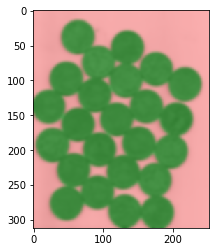

water_coins_segcount3


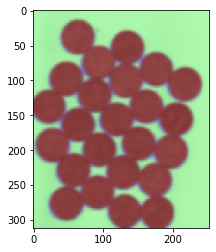

water_coins_segcount4


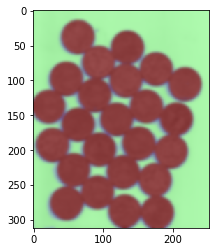

water_coins_segcount5


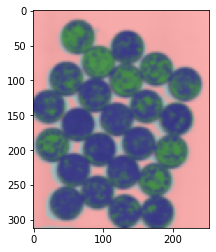



jump_segcount2


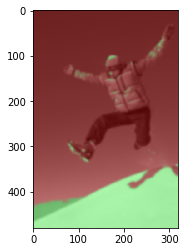

jump_segcount3


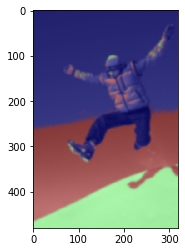

jump_segcount4


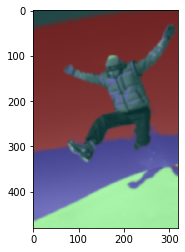

jump_segcount5


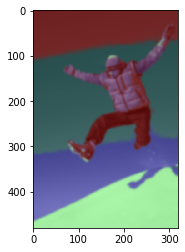



tiger_segcount2


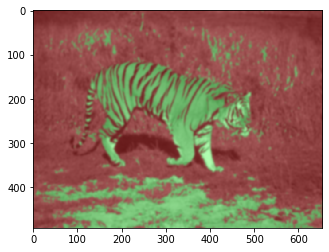

tiger_segcount3


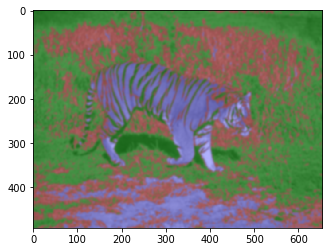

tiger_segcount4


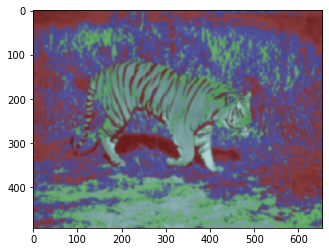

tiger_segcount5


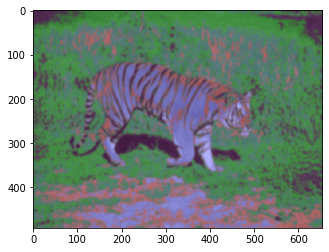